In [1]:
import pandas
import numpy as np
import matplotlib.pyplot as plt
from DE import DiferentialEvolution
from DE import differential_evolution as DE_custom
import cv2
import math

In [2]:
def get_img_averaged(image):
    # Calculate the average color
    average_color = np.mean(image, axis=(0, 1)).astype(int)
    # Create a new image with the same size as the original
    average_color_image = np.full_like(image, average_color)
    return average_color_image

In [3]:
def draw_circle2(image, center_x, center_y, radius, red, green, blue, alpha):
    color = (red, green, blue)
    modified_image = image.copy()
    # Ensure the color values are within the valid range [0, 255]
    color = tuple(int(max(0, min(255, c))) for c in color)
    # Create a circle using OpenCV's circle function
    cv2.circle(modified_image, (center_x, center_y), radius, color, -1)  # -1 means filled
    # Blend the circle with the original image using alpha
    cv2.addWeighted(modified_image, alpha, image, 1 - alpha, 0, modified_image)
    return modified_image

In [4]:
def draw_circle(image, center_x, center_y, radius, red, green, blue, alpha):
    color = (int(abs(red))%256, int(abs(green))%256, int(abs(blue))%256)
    # center_x = int(abs(center_x))
    # center_y = int(abs(center_y))
    modified_image = image.copy()
    radius = int(abs(radius))

    center_x = int(center_x)
    center_y = int(center_y)

    # Create a circle using OpenCV's circle function
    cv2.circle(modified_image, (center_x, center_y), radius, color, cv2.FILLED)  # -1 means filled
    # Blend the circle with the original image using alpha
    cv2.addWeighted(modified_image, alpha, image, 1 - alpha, 0, modified_image)
    return modified_image

In [5]:
def image_difference(img1, img2):
    # Ensure both images have the same dimensions
    if img1.shape != img2.shape:
        raise ValueError("Both images must have the same dimensions")
        
    # Compute the absolute difference between the two images
    diff = cv2.absdiff(img1, img2)
    total_pixels = np.prod(img1.shape[:2])

    # Calculate the percentage of differing pixels
    differing_pixels = np.count_nonzero(diff)
    percentage = (differing_pixels / total_pixels)

    # percentage = np.sum(diff)/total_pixels

    return percentage

def whitespace_difference(refImage, generatedImage,
    thresh=200, type=cv2.THRESH_BINARY_INV, _print=False
):
  # Ensure both images have the same dimensions
  if refImage.shape != generatedImage.shape:
    raise ValueError("Both images must have the same dimensions")

  ref_bw = cv2.cvtColor(refImage,       cv2.COLOR_BGR2GRAY)
  gen_bw = cv2.cvtColor(generatedImage, cv2.COLOR_BGR2GRAY)

  _, ref_bw = cv2.threshold(ref_bw, thresh, 1, type)
  _, gen_bw = cv2.threshold(gen_bw, thresh, 1, type)

  ref_npixels = np.count_nonzero(ref_bw)
  gen_npixels = np.count_nonzero(gen_bw)

  # Check
  if(_print):
    print('whitespace difference:')
    print(ref_npixels, gen_npixels)
    plt.subplot(1,2,1)
    plt.imshow(ref_bw,'gray',vmin=0,vmax=1)
    plt.subplot(1,2,2)
    plt.imshow(gen_bw,'gray',vmin=0,vmax=1)

  return abs(1-gen_npixels/ref_npixels)

def target_func(ind,curr_img, image_obj, RATIO:float=0.4):
    img_modified= draw_circle(curr_img,*ind)
    
    diff = image_difference(image_obj, img_modified)
    w_diff = whitespace_difference(image_obj, img_modified)
    return diff*RATIO + w_diff*(1-RATIO)

In [6]:
def show_img(img):
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

def compare_imgs(img1, img2, TITLE_IMG_DIFF:bool=False):
    if TITLE_IMG_DIFF:
        plt.title(f'{image_difference: .3f}')
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
    plt.show()

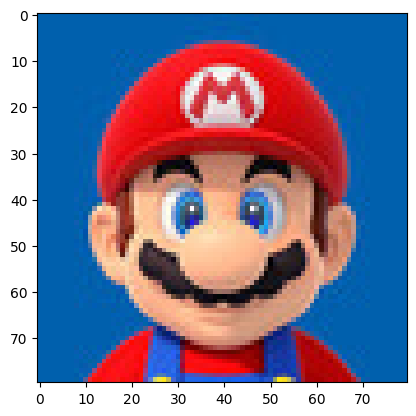

In [7]:
image = cv2.imread('mario_b.jpg')
show_img(image)

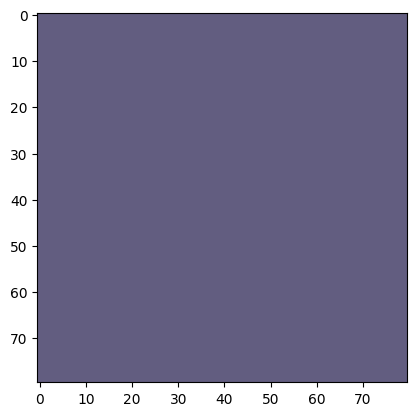

In [8]:
average_color_image = get_img_averaged(image)
show_img(average_color_image)

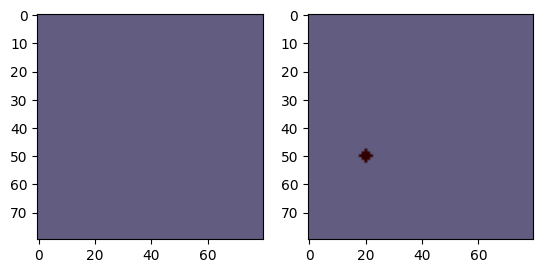

0.00609375
whitespace difference:
6400 6400


0.0

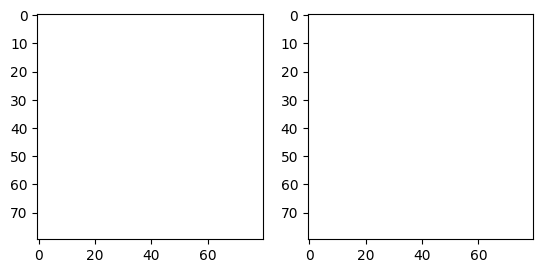

In [9]:
ind = [20,50,2,0,0,50,1]
img_c = draw_circle2(average_color_image, *ind)
compare_imgs(average_color_image,img_c)
print(image_difference(average_color_image, img_c))
whitespace_difference(img_c, average_color_image, _print=True)

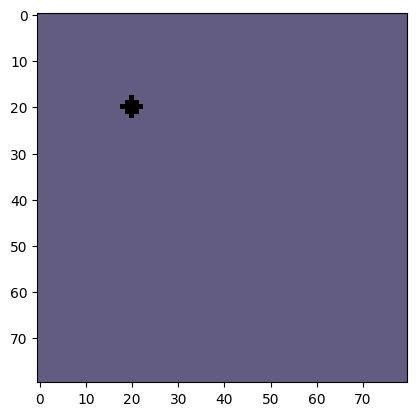

In [10]:
# res =[average_color_image]
img_w_circ = draw_circle(average_color_image, 20,20, 2, 0,0,50, 2)
plt.imshow(cv2.cvtColor(img_w_circ, cv2.COLOR_BGR2RGB))
plt.show()

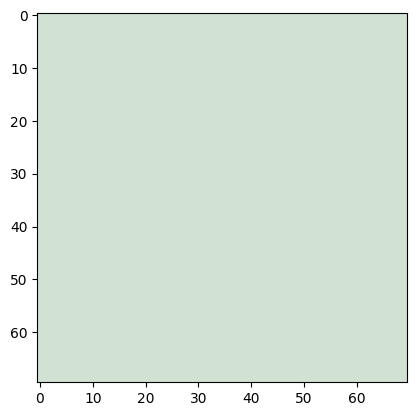

In [11]:
image_obj = cv2.imread('arbol_20.jpg')
curr_img = get_img_averaged(image_obj)
show_img(curr_img)

In [12]:
def solve(img_path, max_it, balance:float = 0.7, PRINT_INT:int=None):
    if PRINT_INT is None:
        PRINT_INT = int(max_it//10)

    image_obj = cv2.imread(img_path)
    curr_img = get_img_averaged(image_obj)
    # curr_img = np.ones_like(image_obj) * 255

    i_x_middle = image_obj.shape[1] / 2
    i_x_disp   = image_obj.shape[1] / 4
    i_y_middle = image_obj.shape[0] / 2
    i_y_disp   = image_obj.shape[0] / 4

    max_r = math.sqrt( (image_obj.shape[1]**2) + image_obj.shape[0]**2 )/8
    bounds = [
        [i_x_middle - i_x_disp, i_x_middle + i_x_disp],
        [i_y_middle - i_y_disp, i_y_middle + i_y_disp],
        [4,max_r],
        [0,255], [0,255], [0,255],
        [0,1]
    ]

    DE = DiferentialEvolution(
        target_func, bounds, args=(curr_img, image_obj, balance),
        popsize=100, mutation=(0.5, 1.0), crossover=0.8,
        maxit=1000, verbose=True, report_interval=1
    )

    for i in range(max_it):
        # custom_de = DE_custom(target_func,bounds,args=(curr_img, image_obj),popsize=30,mutation=(0.5,1.9),crossover=0.7,maxit=100,verbose=False)
        custom_de = DE.optimize()
        sol = custom_de['sol']

        curr_img = draw_circle(curr_img, *sol)
        
        if i%PRINT_INT == 0:
            print(f'circle {i+1}:')
            print(f'   disp:{sol[:2]} r:{sol[2]:.2f} rgb:{sol[3:-1]} al:{sol[-1]:.2f}')
            success = custom_de['success']
            n_it    = custom_de['niter']
            print(f'fitness {target_func(sol, curr_img, image_obj, balance): 0.2f} success:{success} n_it:{n_it}')
            compare_imgs(image_obj, curr_img)
    # end for

    return curr_img

 21.70% elite_idx: 20 n_rep 100/100 elite fitness:  2.3145 
circle 1:
   disp:[137.20409985  17.51031183] r:244.36 rgb:[2174.51341341 1233.63619286 -977.33731109] al:-22.37
fitness  2.62 success:True n_it:217


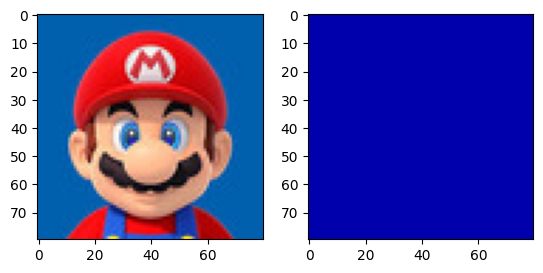

 51.10% elite_idx: 0 n_rep 100/100 elite fitness:  2.0108 
circle 2:
   disp:[-12.82944345  63.26409378] r:-2602.84 rgb:[-1954.78747767    95.76690369  -279.40047351] al:1.32
fitness  2.99 success:True n_it:511


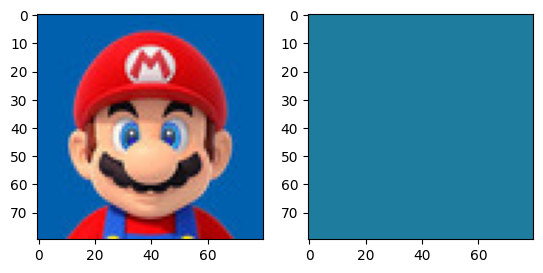

 21.50% elite_idx: 6 n_rep 100/100 elite fitness:  2.3073 
circle 3:
   disp:[-11.12490013 -44.19020002] r:-429.80 rgb:[-3570.26005425   604.94739799 10222.69563302] al:-2.87
fitness  2.62 success:True n_it:215


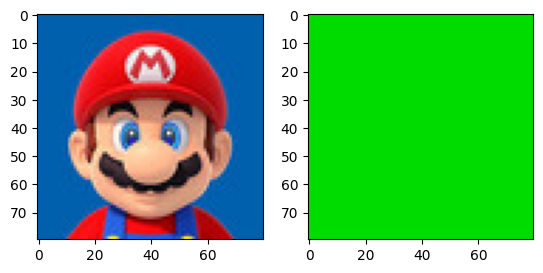

 14.80% elite_idx: 31 n_rep 100/100 elite fitness:  2.3145 
circle 4:
   disp:[ 27.83935981 -38.7949645 ] r:162.64 rgb:[ -647.30116942 -5435.91385161   547.65885002] al:6.42
fitness  2.62 success:True n_it:148


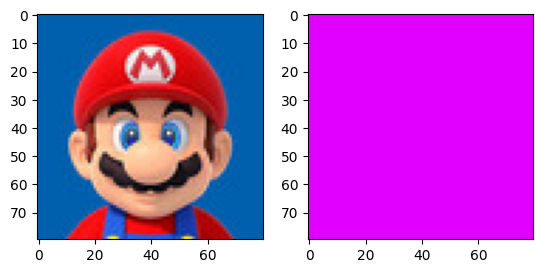

 24.30% elite_idx: 8 n_rep 100/100 elite fitness:  2.3145 
circle 5:
   disp:[196.13586331   4.65419485] r:470.18 rgb:[-121.17663435  374.1685634  7146.97202809] al:-6.37
fitness  2.62 success:True n_it:243


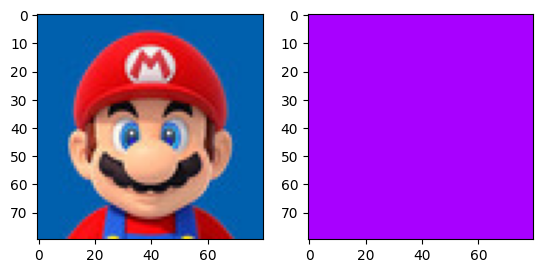

 28.00% elite_idx: 59 n_rep 100/100 elite fitness:  2.3094 
circle 6:
   disp:[118.71066889 115.97951695] r:-2464.56 rgb:[ -1155.03218934 -15453.11382045   -581.76594356] al:14.85
fitness  2.95 success:True n_it:280


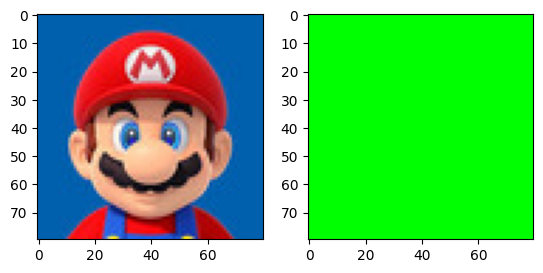

 19.60% elite_idx: 19 n_rep 100/100 elite fitness:  2.3073 
circle 7:
   disp:[134.98114125 106.17316857] r:695.24 rgb:[  490.78308712 -9564.36330331  -995.4637433 ] al:-3.06
fitness  2.62 success:True n_it:196


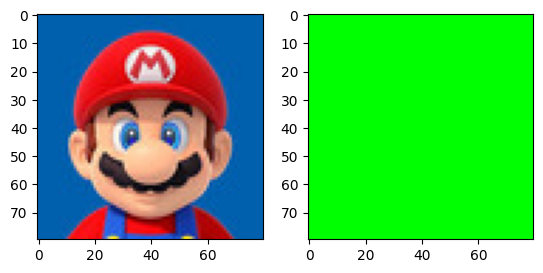

 17.70% elite_idx: 19 n_rep 100/100 elite fitness:  2.3073 
circle 8:
   disp:[131.96189653 -19.75105897] r:1635.47 rgb:[ -749.13279944 -2908.88161129  -689.19557792] al:-2.83
fitness  2.62 success:True n_it:177


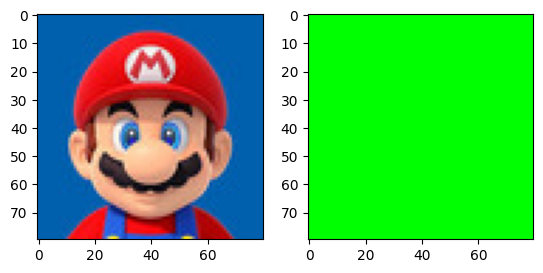

 27.00% elite_idx: 15 n_rep 100/100 elite fitness:  2.3145 
circle 9:
   disp:[ -5.02949385 -92.70026991] r:1030.27 rgb:[ 3450.1551463  -1220.58957849  2170.95003059] al:-7.55
fitness  2.62 success:True n_it:270


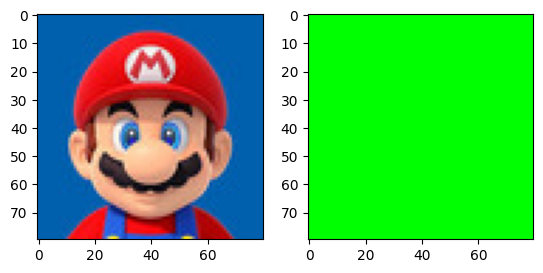

 21.90% elite_idx: 17 n_rep 100/100 elite fitness:  2.3073 
circle 10:
   disp:[258.52595496  60.53144763] r:672.37 rgb:[4100.57454086 1374.948317   -777.55109375] al:2.93
fitness  2.62 success:True n_it:219


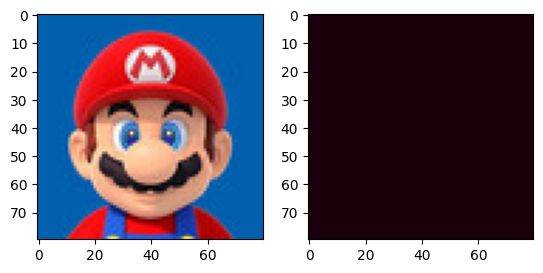

In [13]:
IMAGE_TO_SOLVE = 'mario_b.jpg'
circle_image = solve(IMAGE_TO_SOLVE, 10, balance=1.0, PRINT_INT=1)

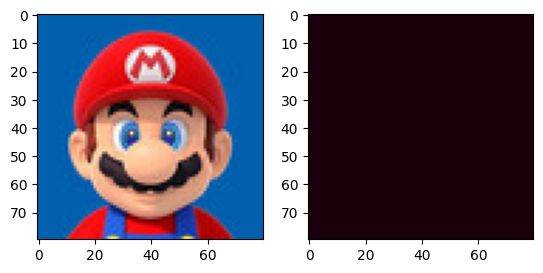

2.98421875
0.07059217129474749


In [15]:
original_img = cv2.imread(IMAGE_TO_SOLVE)
compare_imgs(original_img, circle_image)
print(image_difference(original_img, circle_image))
print(whitespace_difference(original_img, circle_image))